# DLPlan: Description Logics State Features for Planning

## 0. Installation

In [ ]:
!pip install dlplan==0.1.11
!pip install xdot  # to display state spaces

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 748.7/748.7 KB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.4/401.4 KB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.3/222.3 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 MB 8.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
import dlplan

ModuleNotFoundError: ignored

## 1. Expand and Visualize First-order State Spaces


In [ ]:
# 1. Generate state space of Delivery instance with 1 package p and 2 locations a,b
state_space = dlplan.generate_state_space(
    "/content/drive/MyDrive/delivery/domain.pddl", 
    "/content/drive/MyDrive/delivery/instance_1_2.pddl",
    index=0)

Executing "python3 /usr/local/lib/python3.9/dist-packages/state_space_generator/scorpion/fast-downward.py --keep-sas-file /content/drive/MyDrive/delivery/domain.pddl /content/drive/MyDrive/delivery/instance_1_2.pddl --translate-options --dump-static-predicates --dump-predicates --dump-constants --dump-static-atoms --dump-goal-atoms --search-options --search dump_reachable_search_space()"


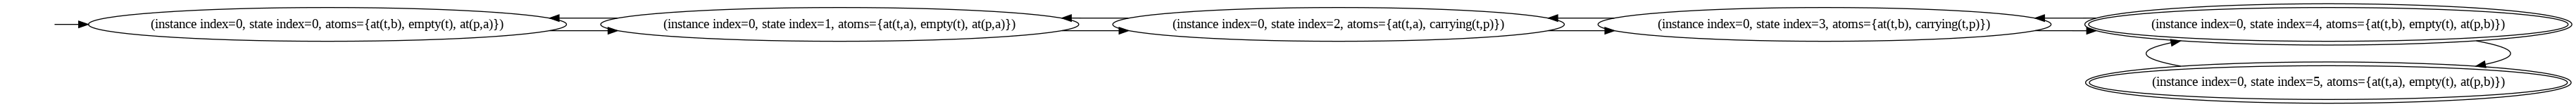

In [ ]:
# 2. View state space
from IPython.display import Image
state_space_dot = state_space.to_dot(1)
with open("graph.dot", "w") as file:
    file.write(state_space_dot)
!dot -Tpng graph.dot > graph.png
Image('graph.png')

## 2. Evaluate Description Logics State Features

In [ ]:
# 1. Parse two features
instance_info = state_space.get_instance_info()
vocabulary_info = instance_info.get_vocabulary_info()
factory = dlplan.SyntacticElementFactory(vocabulary_info)
undelivered_packages = factory.parse_concept(
    "c_and(c_not(c_equal(r_primitive(at,0,1),r_primitive(at_g,0,1))),c_primitive(package,0))")
num_undelivered_packages = factory.parse_numerical(
    "n_count(c_and(c_not(c_equal(r_primitive(at,0,1),r_primitive(at_g,0,1))),c_primitive(package,0)))")

In [ ]:
# 2. Evaluate the features
initial_state = state_space.get_states()[state_space.get_initial_state_index()]
print("Undelivered packages in initial state:", 
      undelivered_packages.evaluate(initial_state))
print("Number of undelivered packages in initial states:", 
      num_undelivered_packages.evaluate(initial_state))

Undelivered packages in initial state: {3}
Number of undelivered packages in initial states: 1


# 3. Generate Description Logics State Features

In [ ]:
# Generate and print feature representations
states = state_space.get_states().values()
feature_reprs = dlplan.generate_features(factory, list(states), feature_limit=400)
print("\n".join(feature_reprs))

In [ ]:
# Concept feature was not pruned
assert undelivered_packages.compute_repr() in feature_reprs
# Numerical feature was pruned
assert num_undelivered_packages.compute_repr() not in feature_reprs